In [1]:
import warnings
import re
from PIL import Image
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

%matplotlib inline

In [2]:
# movie titles
mv_genres = pd.read_csv("../ml-latest/ml-latest/movies.csv")

In [3]:
# movie tags
mv_tags = pd.read_csv("../ml-latest/ml-latest/genome-scores.csv")

In [4]:
# movie tag descriptions
mv_tags_desc = pd.read_csv("../ml-latest/ml-latest/genome-tags.csv")

In [5]:
# clean title in movies.csv file

def movie_title_clean(title):
    
    #     search title for (year) pattern
    s = re.search('\(([^)]+)', title)
    # if pattern exists, remove from string
    year = 9999
    if s:
        title = title[:s.span()[0]].strip()
        year = s.group(1)

    #     check if year is actual year
    if str(year).isdigit():
        year = int(year)
    else:
        year = 9999
    
# if ', The' or ', A' is a the end of the string, move it to the front
  # e.g. change "Illusionist, The" to "The Illusionist"
    
    if title[-5:] == ', The':
        title = 'The ' + title[:-5]
    elif title[-4:] == ', An':
        title = 'An ' + title[:-4]
    elif title[-3:] == ', A':
        title = 'A ' + title[:-3]

    return title, year

In [6]:
# clean title and extract release year
mv_genres["title"] = mv_genres["title"].str.strip()
mv_genres["Title_Year"] = mv_genres["title"].map(movie_title_clean)
mv_genres["Title"] = mv_genres["Title_Year"].apply(lambda x: x[0])
mv_genres["Release Year"] = mv_genres["Title_Year"].apply(lambda x: x[1])

In [7]:
mv_genres.head()

,movieId,title,genres,Title_Year,Title,Release Year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"(Toy Story, 1995)",Toy Story,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,"(Jumanji, 1995)",Jumanji,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,"(Grumpier Old Men, 1995)",Grumpier Old Men,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"(Waiting to Exhale, 1995)",Waiting to Exhale,1995
4,5,Father of the Bride Part II (1995),Comedy,"(Father of the Bride Part II, 1995)",Father of the Bride Part II,1995


In [8]:
# create binary indicators for each genre

mv_genres_stack = mv_genres[mv_genres["genres"] != "(no genres listed)"].set_index("movieId").genres.str.split("|", expand = True).stack()
mv_genres_explode = pd.get_dummies(mv_genres_stack, prefix="g").groupby(level=0).sum().reset_index()
del mv_genres_stack

In [9]:
# genre vector (binary string)
mv_genres_explode["genre_vector"] = mv_genres_explode.iloc[:, 1:].values.tolist()

In [10]:
# check out genre vector
mv_genres_explode.head()

,movieId,g_Action,g_Adventure,g_Animation,g_Children,g_Comedy,g_Crime,g_Documentary,g_Drama,g_Fantasy,...,g_Horror,g_IMAX,g_Musical,g_Mystery,g_Romance,g_Sci-Fi,g_Thriller,g_War,g_Western,genre_vector
0,1,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,2,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,4,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ..."
4,5,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [11]:
# append genre vector
mv_genres = mv_genres.merge(mv_genres_explode[['movieId','genre_vector']], on = 'movieId', how = 'left')

In [12]:
# check out genre dataframe with genre vector
mv_genres.head()

,movieId,title,genres,Title_Year,Title,Release Year,genre_vector
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,"(Toy Story, 1995)",Toy Story,1995,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,2,Jumanji (1995),Adventure|Children|Fantasy,"(Jumanji, 1995)",Jumanji,1995,"[0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,3,Grumpier Old Men (1995),Comedy|Romance,"(Grumpier Old Men, 1995)",Grumpier Old Men,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,"(Waiting to Exhale, 1995)",Waiting to Exhale,1995,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ..."
4,5,Father of the Bride Part II (1995),Comedy,"(Father of the Bride Part II, 1995)",Father of the Bride Part II,1995,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [13]:
# How many tags do we need or each movie??

In [14]:
# nmber of tags
len(np.unique(mv_tags_desc.tagId.values))

1128

In [15]:
# number of movies
len(np.unique(mv_tags.movieId.values))

13176

In [16]:
# number of movie, tag pairs
len(mv_tags)

14862528

In [18]:
# join dataframes to get tag description and movie title name all in one table
mv_tags_denorm = mv_tags.merge(mv_tags_desc, on = 'tagId').merge(mv_genres, on = 'movieId')

# for each movie, compute the relevance rank of tags so we can eventually rank order tags for each movie
mv_tags_denorm['relevance_rank'] = mv_tags_denorm.groupby("movieId")["relevance"].rank(method = "first", ascending = False).astype('int64')

In [20]:
# check out an example of top tags for a movie
mv_tags_denorm[mv_tags_denorm.Title == 'Remember the Titans'][['movieId','Title','tag','relevance','relevance_rank']].sort_values(by = 'relevance', ascending = False).head(10)

,movieId,Title,tag,relevance,relevance_rank
3958984,3916,Remember the Titans,race issues,0.99550,1
3958551,3916,Remember the Titans,football,0.99275,2
3959110,3916,Remember the Titans,sports,0.98550,3
3958266,3916,Remember the Titans,based on true story,0.96125,4
3959049,3916,Remember the Titans,segregation,0.95425,5
3958654,3916,Remember the Titans,high school,0.95075,6
3958538,3916,Remember the Titans,feel good movie,0.94975,7
3958261,3916,Remember the Titans,based on a true story,0.94725,8
3958700,3916,Remember the Titans,inspiring,0.94150,9
3958539,3916,Remember the Titans,feel-good,0.93500,10


In [21]:
# compute median relevance score for each relevance rank
mv_tags_rank_agg = mv_tags_denorm.groupby('relevance_rank')['relevance'].median().reset_index(name = 'relevance_median').head(100)

# compute percent change of median relevance score as we go down in rank
mv_tags_rank_agg['relevance_median_pct_chg'] = mv_tags_rank_agg['relevance_median'].pct_change()

Text(0.5, 1.0, 'Box Plot: Tag Relevance Score by Rank')

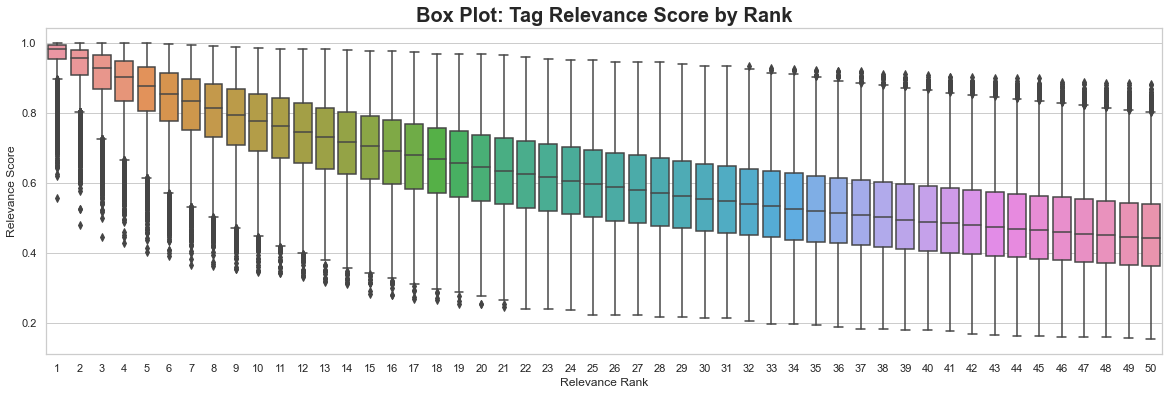

In [22]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(20, 6))

ax = sns.boxplot(x = "relevance_rank", y = "relevance", data = mv_tags_denorm[mv_tags_denorm.relevance_rank <= 50], showfliers = True)
ax.set(ylabel = "Relevance Score")
ax.set(xlabel = "Relevance Rank")
plt.title("Box Plot: Tag Relevance Score by Rank", fontsize = 20, weight = 'bold')